## **Carga inicial de todos lo paquetes**

In [22]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pytrend
import pandas as pd
import zipfile
from scipy.spatial import Delaunay
from inpoly2 import inpoly2
from IDWInterpolation import invDisWgt

## **Carga de tabla principal estaciones temperatura del aire**

In [18]:
dataset_id = '6f02d1394570d4c2'
df = pd.read_csv(dataset_id + '.csv', delimiter='|')
df.head()

,Código Nacional,Nombre Estación,Comuna,Región,Latitud,Longitud,Organismo,Datos Desde,Datos Hasta
0,170001,Visviri Tenencia,General Lagos,Arica y Parinacota,-17.594999,-69.477499,Dirección Meteorológica de Chile,2013,2020
1,170007,Visviri INIA,General Lagos,Arica y Parinacota,-17.594721,-69.475277,Instituto de Investigación Agropecuaria,2019,2023
2,180005,"Chacalluta, Arica Ap.",Arica,Arica y Parinacota,-18.355555,-70.340277,Dirección Meteorológica de Chile,1955,2023
3,180013,El Buitre Arica Ad.,Arica,Arica y Parinacota,-18.508611,-70.287221,Dirección Meteorológica de Chile,1952,1973
4,180017,Putre,Putre,Arica y Parinacota,-18.200000,-69.562500,Dirección Meteorológica de Chile,2017,2023


## **Obtención de estaciones según región y establecimiento de rango de fechas**

In [19]:
startTime = '2016-01-01T00:00:00' # INDICAR FECHA INICIAL
endTime   = '2021-01-01T00:00:00' # INDICAR FECHA FINAL

cut_region = {'01': 'Tarapacá',
              '02': 'Antofagasta',
              '03': 'Atacama',
              '04': 'Coquimbo',
              '05': 'Valparaíso',
              '06': "O'Higgins",
              '07': 'Maule',
              '08': 'Biobío',
              '09': 'La Araucanía',
              '10': 'Los Lagos',
              '11': 'Aysén',
              '12': 'Magallanes y de la Antártica Chilena',
              '13': 'Metropolitana de Santiago',
              '14': 'Los Ríos',
              '15': 'Arica y Parinacota',
              '16': 'Ñuble'}

cut    = '05' # SELECCIONAR REGIÓN
region = cut_region[cut]

df = df[df['Región'].str.contains(region)]
stations = df['Código Nacional'].tolist()
df.head()

,Código Nacional,Nombre Estación,Comuna,Región,Latitud,Longitud,Organismo,Datos Desde,Datos Hasta
51,260007,Isla San Felix,Juan Fernández,Valparaíso,-26.291388,-80.095277,Armada de Chile,2016,2023
53,270001,Mataveri Isla de Pascua Ap.,Isla de Pascua,Valparaíso,-27.158888,-109.432499,Dirección Meteorológica de Chile,1954,2023
104,320019,San Felipe Escuela Agrícola,Valparaíso,Valparaíso,-32.755277,-70.706944,Dirección Meteorológica de Chile,2019,2023
105,320025,"Quintero, Estación Aeronáutica",Quintero,Valparaíso,-32.788888,-71.525554,Dirección Meteorológica de Chile,1952,1982
106,320028,"La Cruz, INIA",La Cruz,Valparaíso,-32.828054,-71.226666,Instituto de Investigación Agropecuaria,2010,2023


## **Descarga y cálculo de temperatura máxima de estaciones filtradas dentro de un intervalo de tiempo**


In [20]:
session = pytrend.itrend_developer_tools()

access_key = 'idtLhlcc7tTpJkobHe6TOluPOs' # Ingresa tu access_key_id
secret_key = 'WtrRDqaZhEqvL8MftSlCgEyrhvoTPwBwUuGlG91sxXAgjLF_oSwRBA' # Ingresa tu secret_access_key

session.set_credentials(
    access_key_id = access_key,
    secret_access_key = secret_key
)

element_formats = session.get_element_formats(dataset_id)
efmt = element_formats[0] # Escoger el formato que más le acomode: element_formats = [npz, mat]

max_temperature = []
for station in stations:
    element_id = str(station)

    if not os.path.exists(element_id + '.npz'):
        element_response = session.download_file(dataset_id, efmt, element_id)

    with np.load(element_id + '.npz', allow_pickle = True) as f:
        data = {}
        for key, value in f.items():
            data[key] = value.item()

    x = data['TS']['x']
    y = data['TS']['y']

    startTime = np.datetime64(startTime)
    endTime   = np.datetime64(endTime)

    ind = np.where((x>=startTime) & (x<=endTime))[0]
    if len(ind) == 0:
        max_temperature.append(0)
    else:
        max_temp = np.max(y[ind])
        max_temperature.append(max_temp)

# Corregir valores 2 veces sobre la media
max_temperature = [1.5 * np.mean(max_temperature) if t > 1.5 * np.mean(max_temperature) else t for t in max_temperature]
max_temperature = np.array(max_temperature)

df.insert(9, 'Temperatura Máxima', max_temperature, True)
df.reset_index(drop=True, inplace=True)

# Remover estaciones sin datos (T = 0) para el intervalo de fechas
ind = np.where(max_temperature==0)[0]
df.drop(ind, inplace=True)
df.reset_index(drop=True, inplace=True)

df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitud, df.Latitud), crs=4326)

lon  = df['Longitud'].tolist()
lat  = df['Latitud'].tolist()
temp = df['Temperatura Máxima'].tolist()
est  = np.array([lon,lat,temp]).T

df.head()

,Código Nacional,Nombre Estación,Comuna,Región,Latitud,Longitud,Organismo,Datos Desde,Datos Hasta,Temperatura Máxima,geometry
0,260007,Isla San Felix,Juan Fernández,Valparaíso,-26.291388,-80.095277,Armada de Chile,2016,2023,25.6,POINT (-80.09528 -26.29139)
1,270001,Mataveri Isla de Pascua Ap.,Isla de Pascua,Valparaíso,-27.158888,-109.432499,Dirección Meteorológica de Chile,1954,2023,29.3,POINT (-109.43250 -27.15889)
2,320019,San Felipe Escuela Agrícola,Valparaíso,Valparaíso,-32.755277,-70.706944,Dirección Meteorológica de Chile,2019,2023,36.7,POINT (-70.70694 -32.75528)
3,320028,"La Cruz, INIA",La Cruz,Valparaíso,-32.828054,-71.226666,Instituto de Investigación Agropecuaria,2010,2023,35.9,POINT (-71.22667 -32.82805)
4,320041,Viña del Mar Ad. (Torquemada),Viña del Mar,Valparaíso,-32.949444,-71.476110,Dirección Meteorológica de Chile,2013,2023,34.2,POINT (-71.47611 -32.94944)


## **Descarga de shapefile con las regiones de Chile**

In [25]:
dataset_id      = dataset_id = 'itrend-ds:F3UP2U3QIAINDHY'
dataset_formats = session.get_dataset_formats(dataset_id)
fmt             = dataset_formats[2] # Escoger el formato que más le acomode: [csv, geojson, shp]
if not os.path.exists('F3UP2U3QIAINDHY.zip'):
  response = session.download_file(dataset_id, fmt)

zip_file    = 'F3UP2U3QIAINDHY.zip'
dest_folder = os.getcwd()
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(dest_folder)

## **Crear grilla de puntos dentro del contorno de la región**

In [ ]:
gdf = gpd.read_file('REGIONES_2020.shp')
gdf = gdf.to_crs(31979)
gdf = gdf.loc[gdf['CUT_REG'] == cut].explode(ignore_index=True, index_parts=None)

# Obtener el índice del polígono más grande de Chile continental para la región especificada
idxmax = gdf['geometry'].area.idxmax()
gdf = gdf.iloc[[idxmax]].drop(['CUT_REG', 'REGION', 'SUPERFICIE'], axis=1)
gdf = gdf.to_crs(4326)

# Seleccionar estaciones dentro de dicho polígono
within_stations = gpd.sjoin(df, gdf, predicate = 'within')

# Grilla en UTM (m) que cubre Chile continental
x = np.arange( -10000,  705000, 1000)
y = np.arange(3730000, 8070000, 1000)

xx, yy = np.meshgrid(x, y)
grid   = np.vstack([xx.ravel(), yy.ravel()]).T
points = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(*zip(*grid)), crs=31979)
points = points.to_crs(4326)

within_points = gpd.sjoin(points, gdf, predicate = 'within')

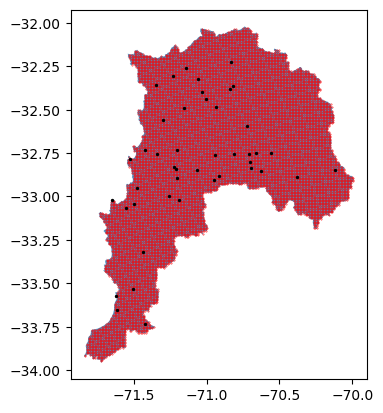

In [28]:
fig, ax = plt.subplots()
gdf.plot(ax = ax, alpha=0.8)
within_points.plot(ax = ax, markersize=0.1, color='r')
within_stations.plot(ax = ax, markersize=2, color='k')
fig.show()

## **Cálculo de mapa de calor**

In [29]:
x = within_points.geometry.x
y = within_points.geometry.y
array   = np.stack([x, y]).T # coordenadas de los puntos dentro del contorno
contour = np.array(gdf.loc[idxmax].geometry.exterior.coords.xy).T

weigthed_array   = invDisWgt(est, array)
weigthed_contour = invDisWgt(est, contour)

griddata = np.vstack([weigthed_array, weigthed_contour])

pts = np.array([griddata[:,0], griddata[:,1]]).T

tri = Delaunay(pts)
tri = tri.simplices

ind = []
cen = []
col = []
for i in list(range(tri.shape[0])):
    cen.append(sum(pts[tri[i]])/3)

cen = np.array(cen)
bol, aux = inpoly2(cen, contour, edge=None, ftol=5.0e-14)

for i in list(range(bol.shape[0])):
    if bol[i] == True:
        ind.append(i)
        col.append(sum(griddata[tri[i]])[2]/3)

<ipython-input-33-1619783388cc>:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb  = ax.figure.colorbar(sm)


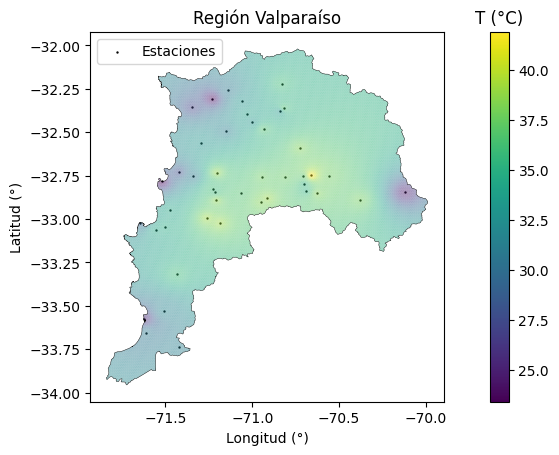

In [33]:
# Especificaciones gráfico
fig, ax = plt.subplots()

ax.scatter(x = within_stations['Longitud'], y = within_stations['Latitud'], color = 'k', s=0.5)
ax.tripcolor(griddata[:,0], griddata[:,1], tri[ind], facecolors = col, antialiased = True, shading='flat', cmap = 'viridis', alpha = 0.5)
ax.plot(contour[:,0], contour[:,1], 'k', linewidth = 0.3)

norm = plt.Normalize(within_stations['Temperatura Máxima'].min(), within_stations['Temperatura Máxima'].max())
sm   = plt.cm.ScalarMappable(cmap = 'viridis', norm = norm)
sm.set_array([])
clb  = ax.figure.colorbar(sm)
clb.ax.set_title('T (°C)')

plt.legend(['Estaciones'], loc='best')
plt.xlabel('Longitud (°)')
plt.ylabel('Latitud (°)')
plt.title('Región '+region)
plt.axis('scaled')
plt.show()

## **Limpiar espacio de trabajo**

In [5]:
for station in stations:
  os.remove(station + '.npz')

os.remove('REGIONES_2020.shp')
os.remove('F3UP2U3QIAINDHY.zip')